# Gravitational Wave Dataset Generator
This notebook generates a dataset of spectrograms from synthetic LIGO-like noise with optional signal injection. It uses the IMRPhenomXPHM waveform model and simulates aLIGO Zero Det High Power noise.
- Each sample lasts 2 seconds
- Sampling rate: 2048 Hz
- Half the samples contain signals; the other half are pure noise
- Output: spectrograms saved as `.npy` files

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pycbc.waveform import get_td_waveform
from pycbc.noise import noise_from_psd
from pycbc.psd import aLIGOZeroDetHighPower, interpolate
from pycbc.types import TimeSeries
from pycbc.filter import sigma
from pycbc.detector import Detector
from scipy.signal import spectrogram


In [32]:
# Parameters
num_samples = 1000
sample_rate = 2048
duration = 4.0
samples = int(sample_rate * duration)
f_lower = 20
snr_range = (30, 30)
nperseg = 512
noverlap = 256
target_time_bins = 31
output_dir = "results"

np.random.seed(42)
os.makedirs(output_dir, exist_ok=True)

# PSD for noise and SNR calculations
psd = aLIGOZeroDetHighPower(length=samples//2 + 1,
                            delta_f=1.0 / duration,
                            low_freq_cutoff=f_lower)


In [33]:
def pad_or_crop(ts: TimeSeries, target_length: int) -> TimeSeries:
    arr = ts.numpy()
    if len(arr) < target_length:
        arr = np.pad(arr, (0, target_length - len(arr)))
    else:
        arr = arr[:target_length]
    return TimeSeries(arr, delta_t=ts.delta_t, epoch=ts.start_time)


  0%|          | 4/1000 [00:01<06:27,  2.57it/s]

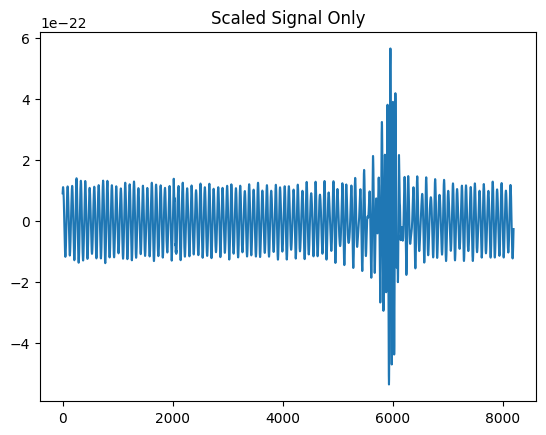

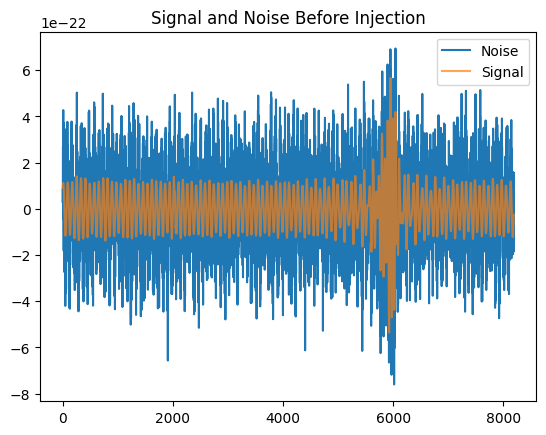

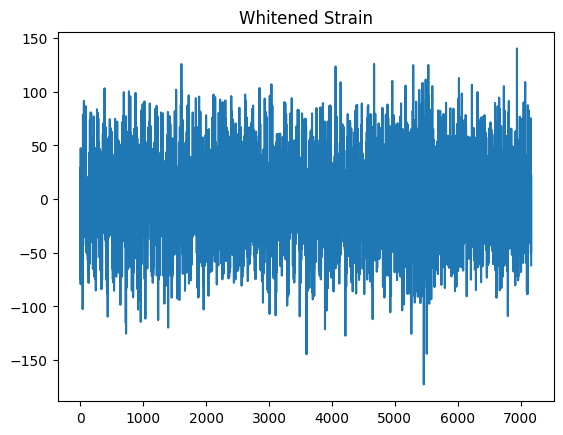

100%|██████████| 1000/1000 [12:12<00:00,  1.36it/s]


In [34]:
x = []
y = []
meta = []
flag = False
labels = np.random.permutation([1] * (num_samples // 2) + [0] * (num_samples - num_samples // 2))

for i in tqdm(range(num_samples)):
    is_signal = labels[i]
    noise = noise_from_psd(length=samples, delta_t=1/sample_rate, psd=psd, seed=i)

    if is_signal:
        mass1 = 30
        mass2 = 30
        spin1z = 0
        spin2z = 0
        inclination = 0
        distance = np.random.uniform(300, 800)
        snr_target = np.random.uniform(*snr_range)

        hp, hc = get_td_waveform(
            approximant="IMRPhenomXPHM",
            mass1=mass1, mass2=mass2,
            spin1z=spin1z, spin2z=spin2z,
            distance=distance,
            inclination=inclination,
            delta_t=1.0 / sample_rate,
            f_lower=30
        )

        detector = Detector("H1")
        fp, fc = detector.antenna_pattern(0, 0, 0, 1000)

        # First: combine hp and hc
        projected = fp * hp + fc * hc

        # Now crop the combined waveform
        signal = pad_or_crop(projected, samples)
        signal.start_time = noise.start_time
        psd_est = interpolate(noise.psd(0.5), delta_f=signal.delta_f)
        sig_snr = sigma(signal, psd=psd_est, low_frequency_cutoff=f_lower)
        scale = snr_target / sig_snr

        # --- Center signal in the noise array ---
        signal_scaled = signal * scale
        signal_np = signal_scaled.numpy()
        noise_np = noise.numpy()

        if flag == False:
            plt.plot(signal_scaled.numpy())
            plt.title("Scaled Signal Only")
            plt.show()

        start = (samples - len(signal_np)) // 2
        noise_np[start:start + len(signal_np)] += signal_np

        if flag == False:
            plt.plot(noise.numpy(), label="Noise")
            plt.plot(signal_scaled.numpy(), label="Signal", alpha=0.7)
            plt.legend()
            plt.title("Signal and Noise Before Injection")
            plt.show()

        strain = TimeSeries(noise_np, delta_t=noise.delta_t, epoch=noise.start_time)

    else:
        strain = noise
        mass1 = mass2 = snr_target = None

    # Whitening
    strain = strain.whiten(1, 0.5)

    if flag == False and is_signal:
        plt.plot(strain.numpy())
        plt.title("Whitened Strain")
        plt.show()
        flag = True


    # Spectrogram
    f, t, Sxx = spectrogram(
        strain.numpy(),
        fs=sample_rate,
        nperseg=nperseg,
        noverlap=noverlap,
        mode="complex"
    )

    Sxx_log = 10 * np.log10(Sxx + 1e-10)
    Sxx_log = (Sxx_log - Sxx_log.mean()) / (Sxx_log.std() + 1e-6)

    # Pad/crop
    if Sxx_log.shape[1] < target_time_bins:
        pad = target_time_bins - Sxx_log.shape[1]
        Sxx_log = np.pad(Sxx_log, ((0, 0), (0, pad)), mode='constant')
    else:
        Sxx_log = Sxx_log[:, :target_time_bins]

    x.append(Sxx_log[..., np.newaxis])
    y.append(is_signal)
    meta.append({
        "index": i, "label": is_signal,
        "mass1": mass1, "mass2": mass2,
        "snr": snr_target
    })


In [35]:
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.int32)

np.save(os.path.join(output_dir, "x.npy"), x)
np.save(os.path.join(output_dir, "y.npy"), y)

import pandas as pd
pd.DataFrame(meta).to_csv(os.path.join(output_dir, "meta.csv"), index=False)

print("✅ Saved:")
print("  X shape:", x.shape)
print("  y shape:", y.shape)


/tmp/ipykernel_27/4099832683.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.array(x, dtype=np.float32)


✅ Saved:
  X shape: (1000, 257, 31, 1)
  y shape: (1000,)


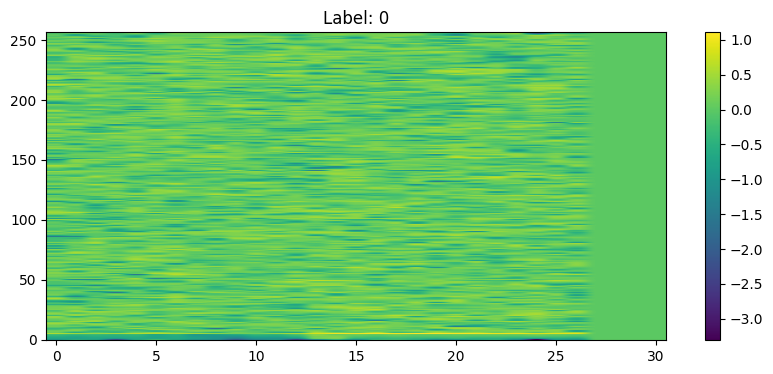

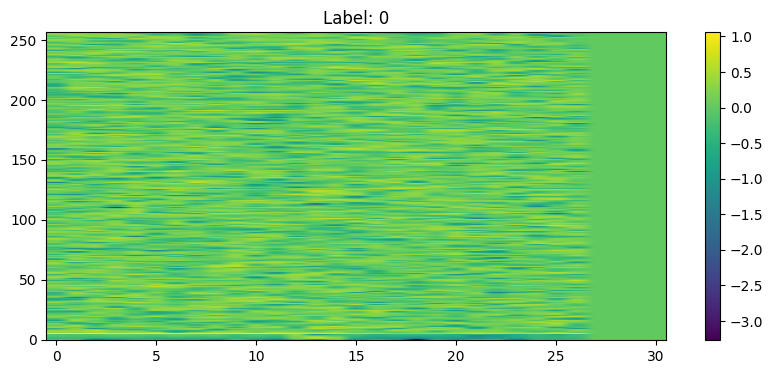

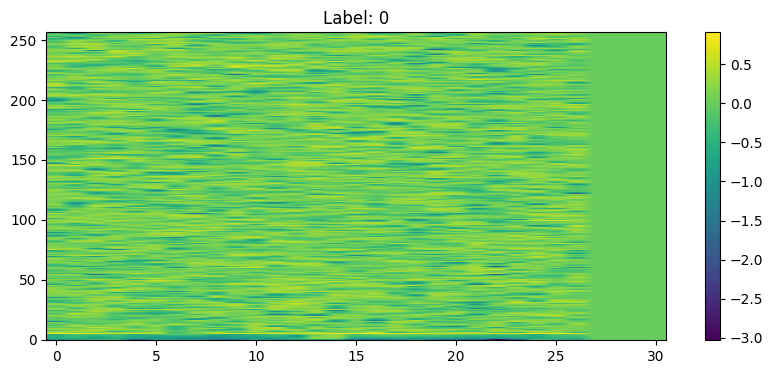

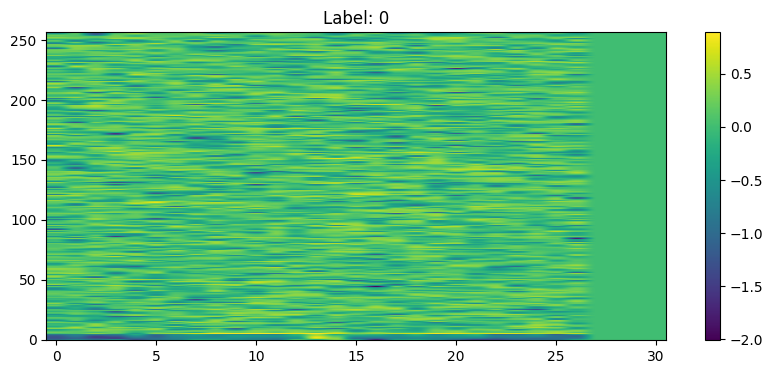

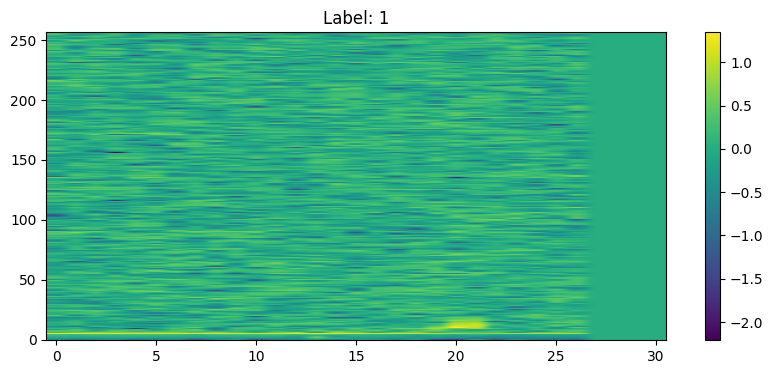

In [36]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(figsize=(10, 4))
    plt.imshow(x[i].squeeze(), aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Label: {y[i]}")
    plt.colorbar()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

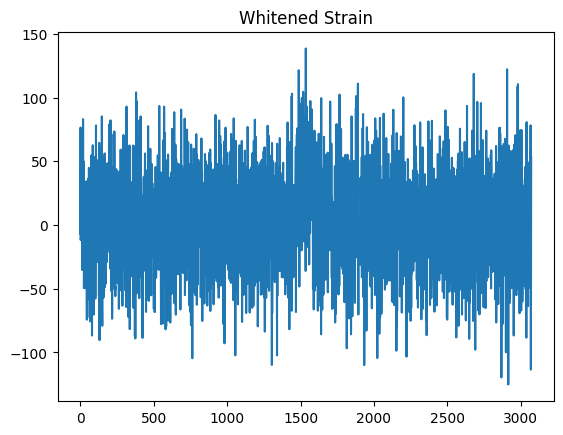

100%|██████████| 1000/1000 [10:43<00:00,  1.55it/s]


✅ Saved:
  X shape: (1000, 129, 30, 1)
  y shape: (1000,)


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pycbc.waveform import get_td_waveform
from pycbc.noise import noise_from_psd
from pycbc.psd import aLIGOZeroDetHighPower, interpolate
from pycbc.types import TimeSeries
from pycbc.filter import sigma
from pycbc.detector import Detector
from scipy.signal import spectrogram
import pandas as pd

# Parameters
num_samples = 1000
sample_rate = 2048
duration = 2.0
samples = int(sample_rate * duration)
f_lower = 20
snr_range = (15, 15)
nperseg = 256
noverlap = 128
target_time_bins = 30
output_dir = "results"

np.random.seed(42)
os.makedirs(output_dir, exist_ok=True)

# PSD for noise and SNR calculations
psd = aLIGOZeroDetHighPower(length=samples // 2 + 1,
                            delta_f=1.0 / duration,
                            low_freq_cutoff=f_lower)

def pad_or_crop(ts: TimeSeries, target_length: int) -> TimeSeries:
    arr = ts.numpy()
    if len(arr) < target_length:
        arr = np.pad(arr, (0, target_length - len(arr)))
    else:
        arr = arr[:target_length]
    return TimeSeries(arr, delta_t=ts.delta_t, epoch=ts.start_time)

x = []
y = []
meta = []
labels = np.random.permutation([1] * (num_samples // 2) + [0] * (num_samples - num_samples // 2))

for i in tqdm(range(num_samples)):
    is_signal = labels[i]
    noise = noise_from_psd(length=samples, delta_t=1/sample_rate, psd=psd, seed=i)

    if is_signal:
        # Fixed signal properties for visibility
        mass1 = mass2 = 30
        spin1z = spin2z = 0
        inclination = 0
        distance = np.random.uniform(300, 800)
        snr_target = np.random.uniform(*snr_range)

        hp, hc = get_td_waveform(
            approximant="IMRPhenomXPHM",
            mass1=mass1, mass2=mass2,
            spin1z=spin1z, spin2z=spin2z,
            distance=distance,
            inclination=inclination,
            delta_t=1.0 / sample_rate,
            f_lower=30
        )

        detector = Detector("H1")
        fp, fc = detector.antenna_pattern(0, 0, 0, 1000)
        projected = fp * hp + fc * hc
        signal = pad_or_crop(projected, samples)
        signal.start_time = noise.start_time

        psd_est = interpolate(noise.psd(0.5), delta_f=signal.delta_f)
        sig_snr = sigma(signal, psd=psd_est, low_frequency_cutoff=f_lower)
        scale = snr_target / sig_snr

        signal_scaled = signal * scale
        signal_np = signal_scaled.numpy()
        noise_np = noise.numpy()
        start = (samples - len(signal_np)) // 2
        noise_np[start:start + len(signal_np)] += signal_np

        strain = TimeSeries(noise_np, delta_t=noise.delta_t, epoch=noise.start_time)

        # Optional plot (only for first signal)
        if i == 0:
            plt.figure()
            plt.plot(signal_scaled.numpy())
            plt.title("Scaled Signal Only")
            plt.show()

            plt.figure()
            plt.plot(noise.numpy(), label="Noise")
            plt.plot(signal_scaled.numpy(), label="Signal", alpha=0.6)
            plt.legend()
            plt.title("Signal and Noise Before Injection")
            plt.show()
    else:
        strain = noise
        mass1 = mass2 = snr_target = None

    # Whitening
    strain = strain.whiten(1, 0.5)

    # Optional plot
    if i == 0:
        plt.figure()
        plt.plot(strain.numpy())
        plt.title("Whitened Strain")
        plt.show()

    # Spectrogram
    f, t, Sxx = spectrogram(
        strain.numpy(),
        fs=sample_rate,
        nperseg=nperseg,
        noverlap=noverlap,
        mode="psd"
    )

    Sxx_log = 10 * np.log10(Sxx + 1e-10)
    # Sxx_log = (Sxx_log - Sxx_log.mean()) / (Sxx_log.std() + 1e-6)

    if Sxx_log.shape[1] < target_time_bins:
        pad = target_time_bins - Sxx_log.shape[1]
        Sxx_log = np.pad(Sxx_log, ((0, 0), (0, pad)), mode='constant')
    else:
        Sxx_log = Sxx_log[:, :target_time_bins]

    if is_signal and i < 3:
        plt.figure()
        plt.imshow(Sxx_log, aspect='auto', origin='lower')
        plt.title(f"SNR: {snr_target:.1f}")
        plt.colorbar()
        plt.show()

    x.append(Sxx_log[..., np.newaxis])
    y.append(is_signal)
    meta.append({
        "index": i,
        "label": is_signal,
        "mass1": mass1,
        "mass2": mass2,
        "snr": snr_target
    })

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.int32)

np.save(os.path.join(output_dir, "x.npy"), x)
np.save(os.path.join(output_dir, "y.npy"), y)
pd.DataFrame(meta).to_csv(os.path.join(output_dir, "meta.csv"), index=False)

print("✅ Saved:")
print("  X shape:", x.shape)
print("  y shape:", y.shape)


After slight improvements

  0%|          | 0/1000 [00:00<?, ?it/s]

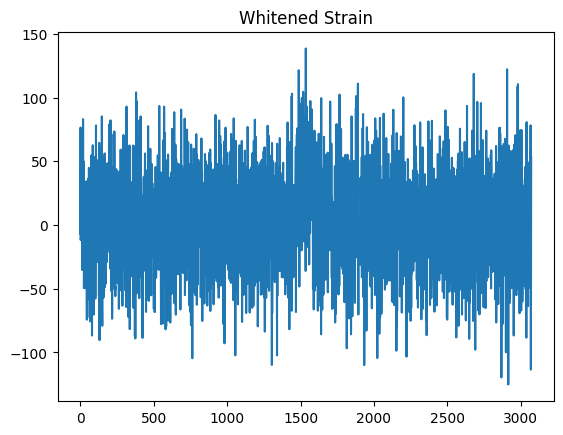

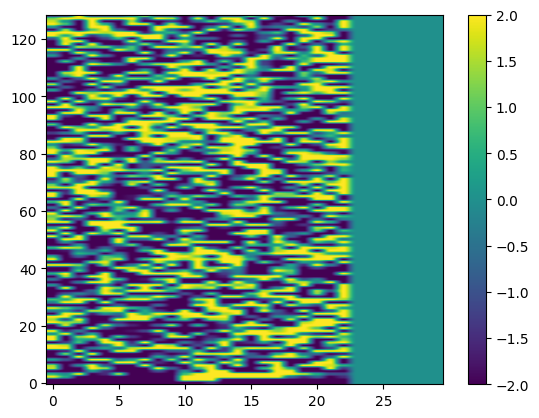

  0%|          | 1/1000 [00:00<11:10,  1.49it/s]

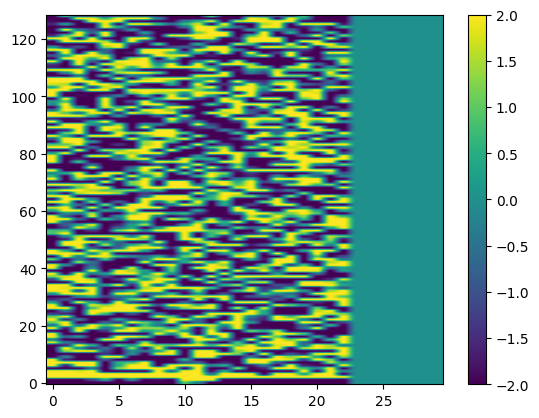

  0%|          | 2/1000 [00:01<10:27,  1.59it/s]

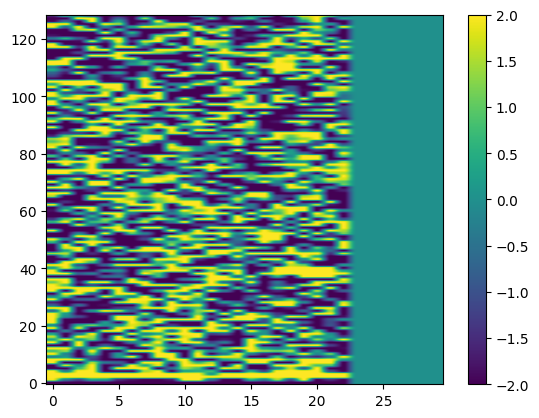

  0%|          | 3/1000 [00:01<10:01,  1.66it/s]

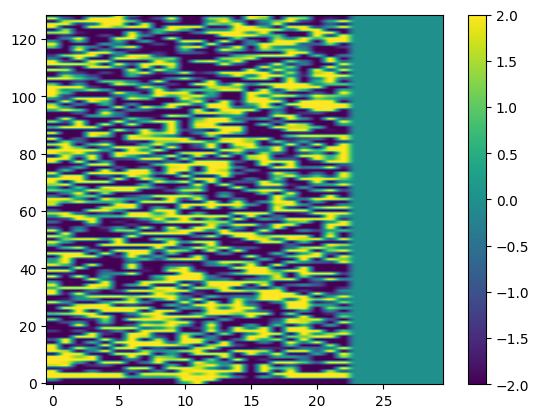

  0%|          | 4/1000 [00:02<09:50,  1.69it/s]

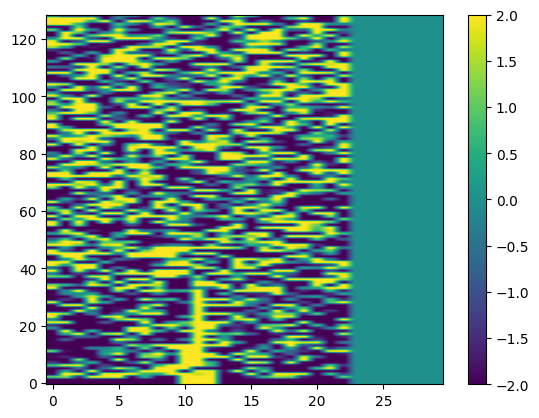

  0%|          | 5/1000 [00:03<14:53,  1.11it/s]

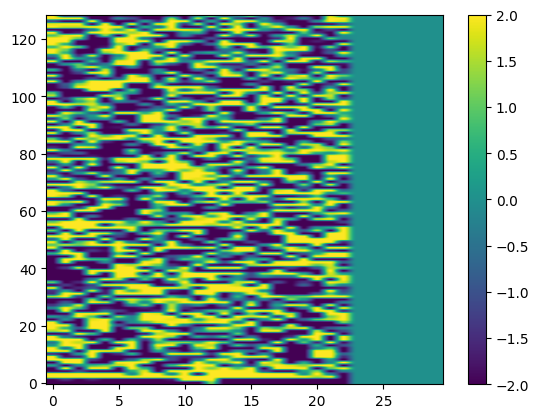

100%|██████████| 1000/1000 [09:43<00:00,  1.71it/s]


✅ Saved:
  X shape: (1000, 129, 30, 1)
  y shape: (1000,)


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pycbc.waveform import get_td_waveform
from pycbc.noise import noise_from_psd
from pycbc.psd import aLIGOZeroDetHighPower, interpolate
from pycbc.types import TimeSeries
from pycbc.filter import sigma
from pycbc.detector import Detector
from scipy.signal import spectrogram
import pandas as pd

# Parameters
num_samples = 1000
sample_rate = 2048
duration = 2.0
samples = int(sample_rate * duration)
f_lower = 20
snr_range = (30, 30)
nperseg = 256
noverlap = 128
target_time_bins = 30
output_dir = "results"

np.random.seed(42)
os.makedirs(output_dir, exist_ok=True)

# PSD for noise and SNR calculations
psd = aLIGOZeroDetHighPower(length=samples // 2 + 1,
                            delta_f=1.0 / duration,
                            low_freq_cutoff=f_lower)

def pad_or_crop(ts: TimeSeries, target_length: int) -> TimeSeries:
    arr = ts.numpy()
    if len(arr) < target_length:
        arr = np.pad(arr, (0, target_length - len(arr)))
    else:
        arr = arr[:target_length]
    return TimeSeries(arr, delta_t=ts.delta_t, epoch=ts.start_time)

x = []
y = []
meta = []
labels = np.random.permutation([1] * (num_samples // 2) + [0] * (num_samples - num_samples // 2))

for i in tqdm(range(num_samples)):
    is_signal = labels[i]
    noise = noise_from_psd(length=samples, delta_t=1/sample_rate, psd=psd, seed=i)

    if is_signal:
        mass1 = mass2 = 30
        spin1z = spin2z = 0
        inclination = 0
        distance = np.random.uniform(300, 800)
        snr_target = np.random.uniform(*snr_range)

        hp, hc = get_td_waveform(
            approximant="IMRPhenomXPHM",
            mass1=mass1, mass2=mass2,
            spin1z=spin1z, spin2z=spin2z,
            distance=distance,
            inclination=inclination,
            delta_t=1.0 / sample_rate,
            f_lower=30
        )

        detector = Detector("H1")
        fp, fc = detector.antenna_pattern(0, 0, 0, 1000)
        projected = fp * hp + fc * hc

        # Center on peak of waveform
        projected_np = projected.numpy()
        center = np.argmax(np.abs(projected_np))
        start = max(0, center - samples // 2)
        end = start + samples
        signal_np = np.zeros(samples)

        if end <= len(projected_np):
            signal_np[:] = projected_np[start:end]
        else:
            extract = projected_np[start:]
            signal_np[:len(extract)] = extract

        signal = TimeSeries(signal_np, delta_t=projected.delta_t, epoch=noise.start_time)
        psd_est = interpolate(noise.psd(0.5), delta_f=signal.delta_f)
        sig_snr = sigma(signal, psd=psd_est, low_frequency_cutoff=f_lower)
        scale = snr_target / sig_snr
        signal *= scale

        noise_np = noise.numpy()
        noise_np += signal.numpy()
        strain = TimeSeries(noise_np, delta_t=noise.delta_t, epoch=noise.start_time)

        if i == 0:
            plt.figure()
            plt.plot(signal.numpy())
            plt.title("Scaled Signal Only")
            plt.show()

            plt.figure()
            plt.plot(noise.numpy(), label="Noise")
            plt.plot(signal.numpy(), label="Signal", alpha=0.6)
            plt.legend()
            plt.title("Signal and Noise Before Injection")
            plt.show()
    else:
        strain = noise
        mass1 = mass2 = snr_target = None

    strain = strain.whiten(1, 0.5)
    strain_np = strain.numpy()

    if i == 0:
        plt.figure()
        plt.plot(strain.numpy())
        plt.title("Whitened Strain")
        plt.show()

    f, t, Sxx = spectrogram(
        strain_np,
        fs=sample_rate,
        nperseg=nperseg,
        noverlap=noverlap,
        mode="psd"
    )

    Sxx_log = 10 * np.log10(Sxx + 1e-10)

    if Sxx_log.shape[1] < target_time_bins:
        pad = target_time_bins - Sxx_log.shape[1]
        Sxx_log = np.pad(Sxx_log, ((0, 0), (0, pad)), mode='constant')
    else:
        Sxx_log = Sxx_log[:, :target_time_bins]

    vmin, vmax = -2, 2
    Sxx_log = np.clip(Sxx_log, vmin, vmax)

    if i < 6:
        plt.figure()
        plt.imshow(Sxx_log, aspect='auto', origin='lower')
        plt.colorbar()
        plt.show()

    x.append(Sxx_log[..., np.newaxis])
    y.append(is_signal)
    meta.append({
        "index": i,
        "label": is_signal,
        "mass1": mass1,
        "mass2": mass2,
        "snr": snr_target
    })

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.int32)

np.save(os.path.join(output_dir, "x.npy"), x)
np.save(os.path.join(output_dir, "y.npy"), y)
pd.DataFrame(meta).to_csv(os.path.join(output_dir, "meta.csv"), index=False)

print("\u2705 Saved:")
print("  X shape:", x.shape)
print("  y shape:", y.shape)
